## Guía 1

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data = pd.read_csv("../datasets/guia_1/2023-03-08 Precios Casas RM.csv") #Importar dataset
#data

In [22]:
#y = data["Price_UF"] #Asignar y como el precio en UF
#data = data.drop(columns=["Price_UF"]) #Eliminar ese precio de data

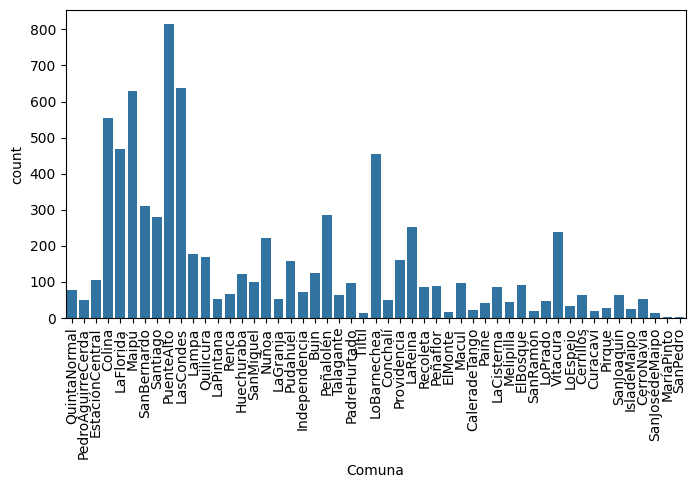

In [23]:
#Plot comunas
plt.figure(figsize=(8,4))
sns.countplot(data, x ="Comuna")
plt.xticks(rotation=90)
plt.show()

In [24]:
data.columns

Index(['Price_CLP', 'Price_UF', 'Price_USD', 'Comuna', 'Ubicacion', 'Dorms',
       'Baths', 'Built Area', 'Total Area', 'Parking', 'id', 'Realtor'],
      dtype='object')

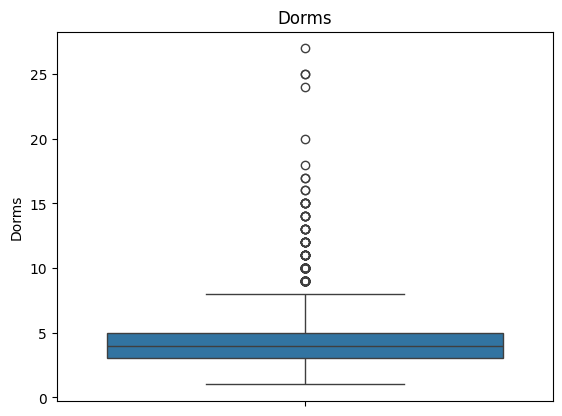

In [25]:
def make_boxplot(data, column): #Funcion para plotear un boxplot de una columna
    sns.boxplot(data, y = column) #Boxplot
    plt.title(column) #Setea el titulo
    plt.show()
make_boxplot(data, "Dorms")

In [26]:
data.describe()

,Price_CLP,Price_UF,Price_USD,Dorms,Baths,Built Area,Total Area,Parking,id
count,7.779000e+03,7779.000000,7.779000e+03,7779.000000,7714.000000,7533.000000,7571.000000,5489.000000,7.779000e+03
mean,3.642481e+08,10234.571153,4.536091e+05,3.994087,2.653746,229.923669,807.919826,2.980506,9.910828e+06
std,3.868810e+08,10870.491584,4.817945e+05,1.622821,1.465103,1676.898812,9050.893115,17.749384,2.046317e+06
min,2.085000e+03,0.000000,3.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.213620e+06
25%,1.200000e+08,3372.000000,1.494400e+05,3.000000,2.000000,85.000000,129.500000,1.000000,8.563078e+06
50%,2.050000e+08,5760.000000,2.552930e+05,4.000000,2.000000,128.000000,210.000000,2.000000,1.054807e+07
75%,4.911420e+08,13800.000000,6.116340e+05,5.000000,3.000000,200.000000,443.000000,3.000000,1.152463e+07
max,5.516450e+09,155000.000000,6.869801e+06,27.000000,29.000000,120000.000000,678000.000000,1269.000000,1.234149e+07


In [27]:
#Filter data
def iqr(data, column): #Inter quantile range
    q3 = data[column].quantile(0.75) #3er cuartil
    q1 = data[column].quantile(0.25) #1er cuartil
    superior_limit = q3 + 1.5*(q3 - q1)
    inferior_limit = q1 - 1.5*(q3 - q1)
    return data[(data[column] < superior_limit) & (data[column] > inferior_limit)] #Selects data

In [28]:
for col in ['Dorms', 'Baths', 'Built Area', 'Total Area', 'Parking']: #Iteration
    data = iqr(data, col) #Uses IQR
    #make_boxplot(data, col) #Plot distr
    #Isolation forest -> sklearn

In [29]:
for column in data.columns: #Iterar las columnas
    data = data[data[column].notna()] #Borrar nulos
    print(column, len(data[data[column].isna()])) #Ver la cantidad de nulos

Price_CLP 0
Price_UF 0
Price_USD 0
Comuna 0
Ubicacion 0
Dorms 0
Baths 0
Built Area 0
Total Area 0
Parking 0
id 0
Realtor 0


In [30]:
data #Display

,Price_CLP,Price_UF,Price_USD,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,id,Realtor
1,105000000,2950,130760,PedroAguirreCerda,Rucalhue,2,1.0,112.0,145.0,1.0,10894299,Legales y Propiedades SpA
2,128124000,3600,159557,EstaciónCentral,AvenidaLasParcelas,3,1.0,59.0,243.0,2.0,10257635,Propiedadesrs
3,75000000,2107,93400,Colina,PasajeGonzaloRojas,3,1.0,103.0,73.0,1.0,9232092,Patricio Gajardo propiedades
4,53000000,1489,66002,Colina,HernánDíazArrieta2820,2,1.0,57.0,67.0,1.0,7085397,Patricio Gajardo propiedades
6,75000000,2107,93400,Colina,GabrielaMistral/PabloNeruda,3,1.0,70.0,80.0,2.0,11688480,Patricio Gajardo propiedades
...,...,...,...,...,...,...,...,...,...,...,...,...
7765,176134910,4949,219346,Maipú,Loprado,6,2.0,181.0,170.0,2.0,6888423,Propiedades Viña Limitada ®
7766,9500,0,12,Pudahuel,DelCrepúsculo1417,4,3.0,235.0,365.0,2.0,7179970,Promoción Inmobiliaria
7767,6800,0,8,Pudahuel,Av.losMolinos1832,3,3.0,100.0,199.0,2.0,7168071,Promoción Inmobiliaria
7768,188627000,5300,234903,EstaciónCentral,LaCoruña5044,4,2.0,114.0,220.0,3.0,4822161,Promoción Inmobiliaria


In [31]:
X = data[["Dorms", "Baths", "Built Area", "Total Area"]] #Select this columns
y = data["Price_UF"]

## Model training

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#Ridge -> Penalty L2
#Lasso -> Penalty L1
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler #Generar la matrix phi y estandarizar
from sklearn.pipeline import Pipeline #Concatenar modelos

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #Dividir en entrenamiento y testing
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2472, 4), (824, 4), (2472,), (824,))

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train) #Training
lr.score(X_train, y_train) #R2 -> Varianza explicada.

0.6337880382568619

In [35]:
rid = Ridge(alpha=0.2) #L2 norm
rid.fit(X_train, y_train)
rid.score(X_train, y_train)

0.6337880373159769

In [36]:
las = Lasso(alpha=0.2) #L1 norm
las.fit(X_train, y_train)
las.score(X_train, y_train)

0.6337880318457348

In [ ]:
ss = StandardScaler() #Agregué un estandarizador X ~ Normal(0,1)
pf = PolynomialFeatures(degree = 2) #Transforma la matriz agregando terminos polinomiales
lr = LinearRegression()
pipe = Pipeline( #Concatenar procesos
    [
        ("standard", ss),
        ("polynomial", pf),
        ("linear regression", lr)
    ]
)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train) #Only training now

0.6681785002399963

In [38]:
cv_score = cross_validate(pipe, X_train, y_train, cv=10)["test_score"] ##Cross validation with K=10
"Mean:", cv_score.mean(), "STD:", cv_score.std()

('Mean:',
 np.float64(0.6595045548782555),
 'STD:',
 np.float64(0.04032867572107581))

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [40]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("mse", mean_squared_error(y_test, y_pred))
print("mae", mean_absolute_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

mse 8649215.543705804
mae 1937.117437923812
r2 0.6570178306184145


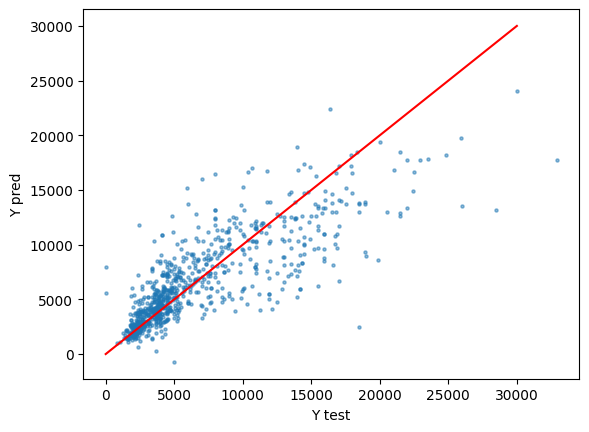

In [41]:
plt.scatter(y_test, y_pred, alpha=0.5, s=5)
plt.xlabel("Y test")
plt.ylabel("Y pred")
plt.plot([0,30000], [0,30000], color="red")
plt.show()

In [42]:
coefs = pd.DataFrame(lr.coef_)
coefs

,0
0,0.000000
1,-293.085572
2,1031.404414
3,1598.261325
4,2135.728764
5,-100.934727
6,-17.716361
7,-185.096274
8,184.871780
9,-295.802324
